In [24]:
import library.Mag as Mag
import numpy as np
from SimPEG import PF, Utils, Mesh, Maps

import matplotlib.pyplot as plt
import ipywidgets as widgets

# 2.1.1.	Magnetic Data Preparation, Gridding, and Visualization#


## Magnetic response of a simple geologic model

The magnetic response (total field anomaly) of the described geologic model is calculated on a series of east-west flight lines running roughly perpendicular to the general strike of geologic boundaries and structures featured in the model. Flight line spacing is 200 m. Data was collected at a flight height of 40 m. Topography is assumed to be flat in this example. The magnetic data are in nanoteslas (NT). 

The default magnetic field values reflect inclination, declination, and field strength recorded in central British Columbia, Canada.  

An East-West profile through the magnetic data is shown. The profile location can be changed using the slider bars. 

-Can E-W profile be defaulted here (aka, azimuth = 90)? rather than N-S (Azimuth = 0)



In [12]:
# Create a survey
topo = np.genfromtxt('TKCtopoDwnS.dat', skip_header=1)
fileName = './DIGHEM_Mag_floor10nt_25m.obs'
xyzd = np.genfromtxt(fileName, skip_header=3)
xyzd[:,-2] = 0
B = np.r_[60308, 83.8, 25.4]
survey = Mag.Mag.createMagSurvey(xyzd, B)
cntr = np.mean(xyzd[:, :2], axis=0)

prisms = []
params = [[2000,500,-100,5000, 4000, 500,60, 0],
          [-500,0,-100,300,300,300,-30,0],
          [200, 100,-100,4000,100,500,55,10],         
         ]         #  [0, 0, -300, 8000, 8000, 2000,0,0],
suscs = [0.1, -0.05, 0.075, 0.005]

# Create the synthetic blocks model and place it at the center of the survey
for param, susc in zip(params, suscs):
    
    prism = Mag.Simulator.definePrism()
    prism.x0, prism.y0, prism.z0 = cntr[0]+param[0], cntr[1]+param[1], xyzd[:, 2].min() +param[2]
    prism.dx, prism.dy, prism.dz = param[3], param[4], param[5]
    prism.pdec, prism.pinc = param[6], param[7]
    
    prisms.append(prism)

    prob = Mag.Mag.problem(prism=prism, survey=survey)
    prob.susc = susc
    survey.dobs += prob.fields()[0]

def Synthetic(View_dip,View_azm,View_lim):

    Mag.Simulator.plotObj3D(prisms, survey, View_dip,View_azm,View_lim, colors=['darkred','darkblue','darkred','r'])
    
    
out = widgets.interactive(Synthetic,
                          View_dip=widgets.FloatSlider(min=0, max=90, step=1, value=90, continuous_update=False),
                          View_azm=widgets.FloatSlider(min=0, max=360, step=1, value=0, continuous_update=False),
                          View_lim=widgets.FloatSlider(min=1, max=2000, step=1, value=870, continuous_update=False),
                          )
# View prism
display(out)

interactive(children=(FloatSlider(value=90.0, continuous_update=False, description='View_dip', max=90.0, step=…

In [13]:
np.kron(np.ones((3,1)), np.r_[2,1,3]).shape

(3, 3)

In [4]:
param = Mag.Simulator.ViewMagSurvey2D(survey)
display(param)

interactive(children=(FloatSlider(value=558034.7817500001, continuous_update=False, description='East', max=56…

In [5]:
print(pts)
mesh.vectorCCz


NameError: name 'pts' is not defined

TypeError: plotSlice() got an unexpected keyword argument 'vmin'

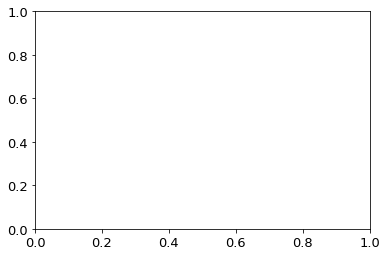

In [30]:
# Descretize the block for plot'
hx = [(20,160)]
hy = [(20,160)]
hz = [(20,60)]
x0 = np.min(xyzd[:,:3], axis=0)
x0[2] -= 1200

#Create a mesh
mesh = Mesh.TensorMesh([hx,hy,hz], x0 = x0)
model = np.zeros(mesh.nC)
for ii, prism in enumerate(prisms):
    X,Y,Z=np.meshgrid(prism.xn, prism.yn, prism.zn)
    pts = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
    
    xyz = Mag.MagUtils.rotate(pts, np.r_[prism.xc, prism.yc, prism.zc], prism.pinc, prism.pdec)
    ind = Utils.ModelBuilder.PolygonInd(mesh, xyz)
    
    model[ind] = ii+1

    
actv = Utils.modelutils.surface2ind_topo(mesh, topo)
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
model = model[actv]
axs=plt.subplot()
indy = int(mesh.vnC[1]/2)-10
im = mesh.plotSlice(actvMap*model, normal='Y', ax=axs, ind=indy, pcolorOpts={'cmap':'jet', 'clim':[0, 3]})
axs.set_title(mesh.vectorCCy[indy])
axs.set_aspect('equal')
# model[indTopo==False] = -100
# mesh.writeModelUBC('ModelInterp.dat',model)
# mesh.writeUBC('Mesh20m.msh')

nan

## Magnetic field effect on response

As discussed in Section 1, the magnetic response will depend on the inclination, declination, and field strength of the magnetic field at the survey location. Use the drop down menu to explore the range of responses that would be measured if this same geologic (and magnetic rock properties) scenario existed at different locations on Earth (sites represent current Mineral Deposit Research Unit project sites). 

-put map and drop down menu here..

## Gridding the magnetic data

Magnetic data should be gridded prior to applying transforms and filters. This means that the flight line data must be interpolated on a regular 2D grid. There are numerous possible ways to grid data. Several researchers have demonstrated that minimum curvature methods are robust and yield a sensible and smooth result, so we have chosen minimum curvature to complete the gridding for this example. In this example, the data are interpolated on a 10 m x 10 m grid. The magnetic field parameters of central BC (Geoscience BC Search II area) are returned to here. 

The resulting gridded data shows the larger and smaller magnetic bodies, and the magnetic low related to the NW trending structure cross-cutting the larger magnetic domain.

## Basic visualization

Simple enhancements to the image can help the user better visualize features within the magnetic data. Applying sun-shading from various angles, experimenting with colour contrast, and adding contour lines are a simple means to explore the data initially. 

Try using the slider bars below to change the direction (SunAzimuth) and angle (SunAngle) of sun shading, to vary color saturation and transparency, and to manipulate magnetic contours lines (MagContour).
   

-don’t think we need vScale


In [ ]:
gridCC, dMinCurv = Mag.Simulator.minCurvatureInterp(
    xyzd[:,:2], survey.dobs,
    vectorX=None, vectorY=None, vectorZ=None, gridSize=10,
    tol=1e-5, iterMax=None, method='spline'
)

X = gridCC[:,0].reshape(dMinCurv.shape, order='F')
Y = gridCC[:,1].reshape(dMinCurv.shape, order='F')

In [ ]:
def dataViewer(X,Y,dataGrid):
      
    def plotData(SunAzimuth,SunAngle,Saturation,Transparency,vScale,MagContour):
        fig = plt.figure(figsize=(8,6))
        axs= plt.subplot()

        # Read the data
#         vmin, vmax = -25, 150
        cmap = plt.cm.gist_earth

        # Add shading
        im, CS = Mag.Simulator.plotDataHillside(X, Y,dataGrid ,
                                  axs=axs, cmap='RdBu_r', 
                                  clabel=False, contour=MagContour,
                                  alpha=Saturation, alphaHS=Transparency, ve=vScale, azdeg=SunAzimuth, altdeg=SunAngle)

        # Add points at the survey locations
        plt.scatter(xyzd[:,0], xyzd[:,1], s=2, c='k')

        # Set limits and labels
#         axs.set_xlim([xmin,xmax])
#         axs.set_ylim([ymin,ymax])
        # axs.set_xticklabels([556750,558000, 559250], size=14)
        # axs.set_xticks([556750,558000, 559250])
        # axs.set_yticklabels([7133000,7134000, 7135000], size=14, rotation=90, va='center')
        plt.colorbar(im)
        # axs.set_yticks([7133000,7134000, 7135000])
        axs.set_xlabel("Easting (m)", size=14)
        axs.set_ylabel("Northing (m)", size=14)
        axs.grid('on', color='k', linestyle='--')
        plt.show()
        # Add colorbar
        # pos = axs.get_position() # Get the position of previous axes
        # axbar = plt.axes([pos.x0+.25, pos.y0+0.2,  pos.width*0.75, pos.height*.5]) # Create a new axes and reshape
        # cbar = plt.colorbar(im, orientation='vertical',format='%.3f') # Add a colorbar using the color definition of previous
        # cbar.set_ticks(np.linspace(-25,300,6)) # Change the tick position
        # cbar.set_ticklabels(np.round(np.linspace(-25,300,6))) # Change the tick labels
        # axbar.text(pos.x0+1., pos.y0+.75,'SI', size=14) # Add units and move it above
        # axbar.axis('off') # Only keep the colorbar, remove the rest

    out = widgets.interactive(plotData,
                              SunAzimuth=widgets.FloatSlider(min=0, max=360, step=5, value=0, continuous_update=False),
                              SunAngle=widgets.FloatSlider(min=0, max=90, step=5, value=45, continuous_update=False),
                              Saturation=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, continuous_update=False),
                              Transparency=widgets.FloatSlider(min=0, max=1, step=0.1, value=1.0, continuous_update=False),
                              vScale=widgets.FloatSlider(min=1, max=1000, step=1., value=1.0, continuous_update=False),
                              MagContour=widgets.FloatSlider(min=0, max=20, step=1, value=10, continuous_update=False))
    return out

view = dataViewer(X, Y, dMinCurv)
display(view)

In [ ]:

            
    #             if shape.record[18]=='Canada':
    #                 poly2D = Polygon(np.c_[np.vstack(x),np.vstack(y)])
    # #                 pcolor += [cpool[units[ii]]]
    #                 patches.append(poly2D)
    #                 else:
                

In [ ]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import json
import re

%pylab inline
# Load world shapefile
# world = shapefile.Reader('./assets/worldShapefile/ne_50m_admin_0_countries.shp')
world = shapefile.Reader('./assets/Continents/continent.shp')
X, Y = [],[]
for shape in world.shapeRecords():

    for ii, part in enumerate(shape.shape.parts):

#             if ii > 10:
#                 continue
        if ii != len(shape.shape.parts)-1:
            x = [i[0] for i in shape.shape.points[shape.shape.parts[ii]:shape.shape.parts[ii+1]:50]]
            y = [i[1] for i in shape.shape.points[shape.shape.parts[ii]:shape.shape.parts[ii+1]:50]]

        else:
            x = [i[0] for i in shape.shape.points[shape.shape.parts[ii]::50]]
            y = [i[1] for i in shape.shape.points[shape.shape.parts[ii]::50]]
    
        if len(x) > 10:
            X.append(np.vstack(x))
            Y.append(np.vstack(y))
        
# Load in the pre-defined locations
with open('./assets/MAGlocations_w_field.json', 'r') as fp:
    data = json.load(fp)
    

In [ ]:
data

In [ ]:
# cities = shapefile.Reader('./assets/worldShapefile/ne_10m_populated_places_simple.shp')
def mapViewer(world, data):
    def plotCountry(X,Y, ax=None, fill=True, linewidth=1):
        
        for x,y in zip(X,Y):
            ax.plot(x, y,'k', linewidth=linewidth)

        return ax

                
    def plotLocs(placeID):
        
        selection =int(np.r_[[ii for ii, s in enumerate(list(data.keys())) if placeID in s]])
        dataVals = list(data.values())[selection]
        
        survey = Mag.Mag.createMagSurvey(xyzd, B)

        # Create the synthetic blocks model and place it at the center of the survey
        for param, susc in zip(params, suscs):

            prism = Mag.Simulator.definePrism()
            prism.x0, prism.y0, prism.z0 = cntr[0]+param[0], cntr[1]+param[1], xyzd[:, 2].min() +param[2]
            prism.dx, prism.dy, prism.dz = param[3], param[4], param[5]
            prism.pdec, prism.pinc = param[6], param[7]

            prob = Mag.Mag.problem(prism=prism, survey=survey)
            prob.susc = susc
            prob._Higrf = dataVals[4]
            prob._Hinc = dataVals[3]
            prob._Hdec = dataVals[2]
            
            
            survey.dobs += prob.fields()[0]

#         param = Mag.Simulator.ViewMagSurvey2D(survey)
#         display(param)

        plt.figure(figsize=(10,10))
        ax1 = plt.subplot(1,2,2)
        fig, im = Mag.Simulator.plotData2D(survey.srcField.rxList[0].locs, d=survey.dobs,
                                 ax=ax1, cmap='RdBu_r', marker=False, contours=[0], colorbar=False)
        
        plt.colorbar(im, orientation='horizontal')
                   
        axs = plt.subplot(1,2,1)
        axs = plotCountry(X,Y, ax=axs, fill=False)
        # xydata = np.loadtxt("./assets/country-capitals.csv", delimiter=",")
        for key, entry in zip(list(data.keys()),list(data.values())):
            axs.scatter(entry[1],entry[0], c='k')
        
        
        
        axs.scatter(dataVals[1],dataVals[0], s = 50, c='r', marker='s', )
        axs.set_aspect('equal')
        plt.show()
        
        return axs
    
    out = widgets.interactive(plotLocs,
                        placeID = widgets.Dropdown(
                        options=list(data.keys()),
                        value=list(data.keys())[0],
                        description='Number:',
                        disabled=False,
                        ))
                        
    
    return out

view = mapViewer(world, data)
display(view)

In [ ]:

# raw = {"Geoscience BC SeArch II area":["54d19m51.68N","125d43m43.7W"],
# "Turkey (Kisladag mine area)":["38d28m55.25N","29d8m53.71E"],
# "Nevada (Goldstrike mine area)":["40d58m54.04N","116d22m45.92W"],
# "Peru (Antamina mine area)":["9d32m21.53S","77d3m48.41W"],
# "Yukon (Dawson city area)":["64d3m35.28N","139d25m56.34W"],
# "Colombia (El Alacran deposit area)":["7d44m46.27N","75d43m7.17W"],
# "Serbia (Bor mine area)":["44d5m21.33N","22d5m59.92E"],
# "Chile (Atacama desert, Chiquicamata mine area)":["22d17m13.10S","68d54m9.20W"]}

# newDict = {}
# for key, entry in zip(list(raw.keys()),list(raw.values())):
    
#     temp = [float(val) for val in re.findall('[-+]?\d*\.\d+|\d+',entry[0])]
#     lat = temp[0] + temp[1]/60. + temp[2]/3600.
#     if entry[0][-1]=='S':
#         lat *= -1

#     temp = [float(val) for val in re.findall('[-+]?\d*\.\d+|\d+',entry[1])]
#     lon = temp[0] + temp[1]/60. + temp[2]/3600.
#     if entry[1][-1]=='W':
#         lon *= -1

#     newDict[key] =[lat, lon]
# with open('MAGlocations.json', 'w') as fp:
#     json.dump(newDict, fp)






## Advanced visualization

Addional image processing can be done to explore the range of magnetic responses within the data. Applying various color scales and stretches benefits the geophysical data interpretion as this provides a more complete overview of features in the data, which might be obscured when only one set of display parameters is applied.  